[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [1]:
#run this once
import os, IPython
os.system("apt-get install -qq curl g++ make; curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz")
os.chdir('spatialindex-src-1.8.5')
os.system("./configure; make; make install; pip install rtree ;ldconfig")
os.chdir('/content')
os.system('apt-get update; apt-get install -y libproj-dev proj-data proj-bin libgeos-dev libspatialindex-dev')
os.system('pip install pysal cython cartopy geoplot geopandas osmnx coverage coveralls folium pytest scikit-learn scipy sphinx twine  descartes Shapely')
os.system("wget -O /usr/local/lib/python3.6/dist-packages/osmnx/footprints.py https://raw.githubusercontent.com/gboeing/osmnx/master/osmnx/footprints.py")

0

In [0]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import Image
import seaborn as sns
import pandas as pd
import folium
from folium import plugins

In [0]:
#finds number of buildings present inside the radius of the coordinate
def calculate_intensity(coord_map, radius):

  print(coord_map.shape)
  
  num = 0
  lat_list = list()
  long_list = list()
  density_list = list()
  heatmap = np.zeros((coord_map.shape[0], coord_map.shape[1]))
  for row_index in range(coord_map.shape[0]):

    row = coord_map[row_index]
    for col_index in range(coord_map.shape[1]):
      num += 1
      print(num)
      try:
        point = row[col_index]
        gdf = ox.footprints.footprints_from_point(np.array(point), distance = radius, footprint_type = 'building')
        proj = ox.project_gdf(gdf)
        
        #this logic will be improved later
        #num of buildings can be made into categorical value while building the model.
        num_buildings = proj.shape[0]
        heatmap[row_index, col_index] = num_buildings
        lat_list.append(point[0])
        long_list.append(point[1])
        density_list.append(num_buildings)
      except:
        pass
  density_df = pd.DataFrame(columns = ['latitude', 'longitude', 'density'])
  density_df['latitude'] = lat_list
  density_df['longitude'] = long_list
  density_df['density'] = density_list
  return heatmap, density_df

In [0]:
#distance between pair of lat long coordinates
def distance(p1, p2):
  lat_1 = (p1[0]) * math.pi / 180.0
  lat_2 = (p2[0]) * math.pi / 180.0
  lat_diff = lat_1 - lat_2
  long_diff = (p1[1] - p2[1]) * math.pi / 180.0

  a = math.pow(math.sin(lat_diff / 2), 2) + math.pow(math.sin(long_diff / 2), 2) + math.cos(lat_1) * math.cos(lat_2)
  rad = 6371
  return rad * math.asin(math.sqrt(a)) * 2

In [0]:
def get_heatmap(tl_coord, br_coord, grid_size, radius_mtr):
  '''
  tl_coord  coordinate of top left corner.
  br_coord  coordinate of bottom left corner.
  grid_size number of intermediate (lat, long) around which density is calculated.
  radius_mtr  number of buildings which lies inside the given radius(meters) around a point are considered.
  '''
  coord_map = np.zeros((grid_size[0], grid_size[1], 2))#stores all the intermediate coordinates for the given rectangle boundary
  tr_coord = (br_coord[0], tl_coord[1])
  bl_coord = (tl_coord[0], br_coord[1])

  #dist_x = distance(tl_coord, tr_coord)
  #dist_y = distance(tl_coord, bl_coord)
  step_x = (tl_coord[0] - tr_coord[0]) / grid_size[0]
  step_y = (tl_coord[1] - bl_coord[1]) / grid_size[1]
  print(f"step x: {step_x} step y: {step_y}")#coordinates are increased by these step values

  #creates a map of coordinates for which density is to found
  print("calculating coordinates")
  x_value = tl_coord[0]
  for x_index in range(grid_size[0]):
    x_value += step_x
    y_value = tl_coord[1]
    for y_index in range(grid_size[1]):
      y_value += step_y
      coord_map[x_index,y_index][0] = x_value
      coord_map[x_index, y_index][1] = y_value

  print("creating heatmap")
  heatmap, density_df = calculate_intensity(coord_map, radius_mtr)
  print("done")
  return heatmap, density_df

In [0]:
#takes time to complete
#reduce the grid size for making it faster
heatmap, density_df = get_heatmap((41.003508, 29.203245), (40.977055, 29.249251), (20, 20), 200)

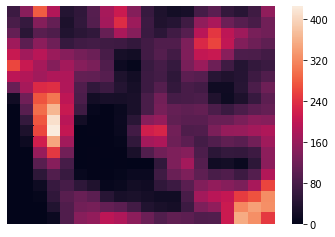

In [28]:
img = sns.heatmap(heatmap, xticklabels = False, yticklabels = False)
#img.get_figure().savefig('test.png')

In [0]:
#visualize the heatmap on the map
def visualize_heatmap(density_df):

  den_100 = density_df.query('density <= 100')
  den_200 = density_df.query('density > 100 and density <= 200')
  den_300 = density_df.query('density > 200')

  point = density_df.loc[0]
  geo_map = folium.Map((point['latitude'], point['longitude']), zoom_start = 10)
  heat_df_100= den_100[['latitude', 'longitude']]
  heat_df_200 = den_200[['latitude', 'longitude']]
  heat_df_300 = den_300[['latitude', 'longitude']]


  geo_map.add_child(plugins.HeatMap(heat_df_100.as_matrix(), radius = 20, min_opacity = 0.5, gradient = {0.4: 'blue', 0.65: 'blue', 1: 'lime'}))
  geo_map.add_child(plugins.HeatMap(heat_df_200.as_matrix(), radius = 20, min_opacity = 0.5, gradient = {0.4: 'lime', 0.65: 'lime', 1: 'red'}))
  geo_map.add_child(plugins.HeatMap(heat_df_300.as_matrix(), radius = 25, min_opacity = 0.5, gradient = {0.4: 'red', 0.65: 'red', 1: 'red'}))
  geo_map.save('map.html')
  return geo_map

In [117]:
geo_map = visualize_heatmap(density_df)
geo_map

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [101]:
#workaround for finding width of road.
#we can assign discrete value for each road type as roads belonging to same category will have similar width
point = (40.982911, 29.243035)
radius = 200

g = ox.core.graph_from_point(np.array(point), distance = radius, infrastructure = 'way["highway"]')
g = ox.project_graph(g)
nodes, edges = ox.graph_to_gdfs(g)
edges.shape
print(edges['highway'].unique())

['residential' 'tertiary']
